In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

In [2]:
def load_data(data_dir):
    '''
    Carrega os arquivos da pasta, separando as imagens e os labels correspondentes já codificados 
    '''
    # Lista para armazenar imagens e rótulos
    images = []
    labels = []
    
    # Loop sobre os arquivos no diretório
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):  # Imagens tem extensão .png
            img = load_img(os.path.join(data_dir, filename), target_size=(300, 300))
            img_array = img_to_array(img)
            images.append(img_array)
            
            # Extrair rótulo do nome do arquivo
            label = filename.split(' ')[0]  # Pega o rótulo antes do espaço em branco
            labels.append(label)

    # Codificar rótulos em números
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Converter para array numpy
    images = np.array(images)
    labels = to_categorical(labels)

    return images, labels, label_encoder

In [3]:
def compute_class_weights(y_train):
    # Calcular pesos das classes baseados na distribuição dos dados
    class_weights = {}
    total_samples = len(y_train)
    num_classes = len(np.unique(np.argmax(y_train, axis=1)))
    for i in range(num_classes):
        class_count = np.sum(np.argmax(y_train, axis=1) == i)
        class_weights[i] = total_samples / (num_classes * class_count)

    return class_weights

In [4]:
def get_model(input_shape=(300,300,3), num_class=3):
    # Carregar o modelo VGG-16 pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar as camadas do modelo base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Adicionar camadas personalizadas
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))  # 3 classes: benign, malign, normal
    
    # Compilar o modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Apresenta um sumário do modelo
    #model.summary()

    return model

In [5]:
def classification_metrics_multiclass(y_true, y_pred, model, fold):
    '''
    Generate multiclass classification analysis
    '''
    
    # Confusion matrix for multiclass
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_score_per_class = f1_score(y_true, y_pred, average=None)
    
    # Overall metrics
    accuracy = (cm.diagonal().sum()) / cm.sum()
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    try:
        auc_value = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except ValueError:
        auc_value = None  # AUC calculation might fail if there's not enough variety in predictions
    
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        "model": model, 
        "fold": fold,
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(), 
        "recall_per_class": recall_per_class.tolist(), 
        "f1_score_per_class": f1_score_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_score_macro": f1_score_macro,
        "auc": auc_value, 
        "kappa": kappa
    }

In [6]:
def plot_cm(y_true, y_pred_classes, label_encoder):
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
# Diretório com suas imagens
data_dir = 'C:/Users/estel/Documents/Python_Codes/breast_cancer/preprocessed/images/'

# Carregar os dados
images, labels, label_encoder = load_data(data_dir)

# Parametros
input_shape = (300, 300, 3)
num_classes = 3  # Número de classes: benign, malign, normal

In [8]:
# Definir a validação cruzada k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

---------
Starting Fold: 1 ...
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 955s 35s/step - accuracy: 0.4969 - loss: 20.9542 - val_accuracy: 0.7051 - val_loss: 7.9778
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 324s 16s/step - accuracy: 0.8001 - loss: 5.4764 - val_accuracy: 0.7244 - val_loss: 5.5119
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 324s 16s/step - accuracy: 0.8658 - loss: 2.0327 - val_accuracy: 0.7051 - val_loss: 4.8954
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step


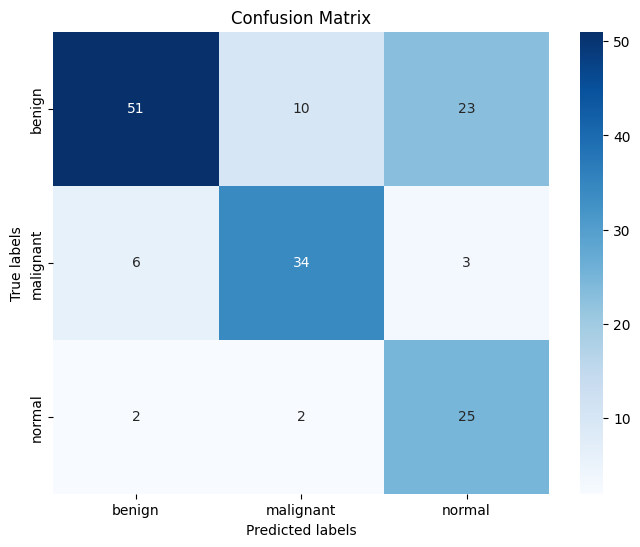

{'model': 'vgg16', 'fold': 1, 'confusion_matrix': array([[51, 10, 23],
       [ 6, 34,  3],
       [ 2,  2, 25]], dtype=int64), 'accuracy': 0.7051282051282052, 'precision_per_class': [0.864406779661017, 0.7391304347826086, 0.49019607843137253], 'recall_per_class': [0.6071428571428571, 0.7906976744186046, 0.8620689655172413], 'f1_score_per_class': [0.7132867132867133, 0.7640449438202247, 0.625], 'precision_macro': 0.6979110976249995, 'recall_macro': 0.753303165692901, 'f1_score_macro': 0.700777219035646, 'auc': None, 'kappa': 0.5493311561891603}
---------
Starting Fold: 2 ...
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 468s 20s/step - accuracy: 0.4186 - loss: 42.6264 - val_accuracy: 0.6218 - val_loss: 8.8927
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 336s 17s/step - accuracy: 0.7126 - loss: 6.0568 - val_accuracy: 0.8013 - val_loss: 2.1655
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step - accuracy: 0.8713 - loss: 1.0217 - val_accuracy: 0.8013 - val_loss: 1.1381
5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 13s/ste

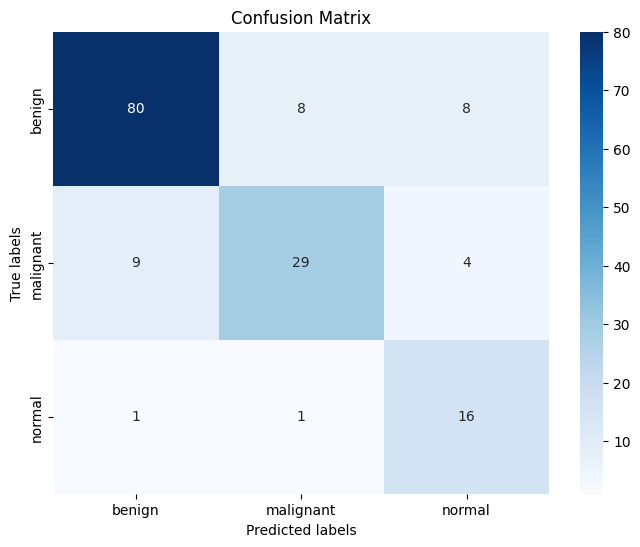

{'model': 'vgg16', 'fold': 2, 'confusion_matrix': array([[80,  8,  8],
       [ 9, 29,  4],
       [ 1,  1, 16]], dtype=int64), 'accuracy': 0.8012820512820513, 'precision_per_class': [0.8888888888888888, 0.7631578947368421, 0.5714285714285714], 'recall_per_class': [0.8333333333333334, 0.6904761904761905, 0.8888888888888888], 'f1_score_per_class': [0.8602150537634409, 0.725, 0.6956521739130435], 'precision_macro': 0.7411584516847673, 'recall_macro': 0.8042328042328042, 'f1_score_macro': 0.7602890758921615, 'auc': None, 'kappa': 0.6443071491615181}
---------
Starting Fold: 3 ...
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 621s 22s/step - accuracy: 0.4469 - loss: 36.4186 - val_accuracy: 0.7949 - val_loss: 2.0886
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 337s 17s/step - accuracy: 0.8324 - loss: 1.9614 - val_accuracy: 0.7756 - val_loss: 1.1618
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 322s 16s/step - accuracy: 0.9003 - loss: 0.3150 - val_accuracy: 0.7949 - val_loss: 0.8171
4/5 ━━━━━━━━━━━━━━━━━━━━ 12s 13s/s

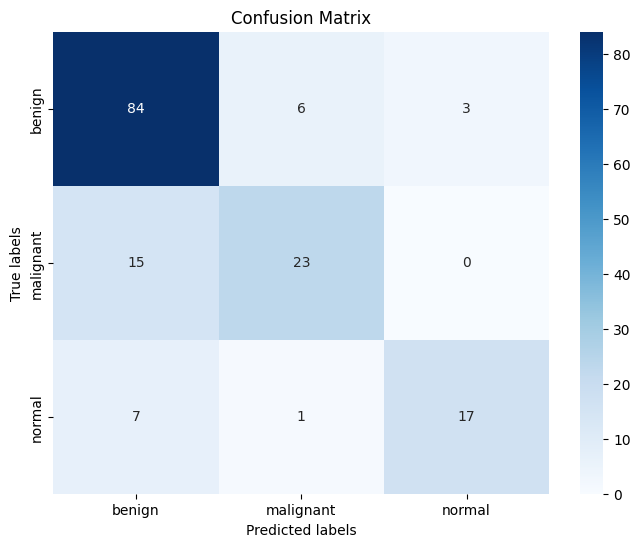

{'model': 'vgg16', 'fold': 3, 'confusion_matrix': array([[84,  6,  3],
       [15, 23,  0],
       [ 7,  1, 17]], dtype=int64), 'accuracy': 0.7948717948717948, 'precision_per_class': [0.7924528301886793, 0.7666666666666667, 0.85], 'recall_per_class': [0.9032258064516129, 0.6052631578947368, 0.68], 'f1_score_per_class': [0.8442211055276382, 0.6764705882352942, 0.7555555555555555], 'precision_macro': 0.8030398322851154, 'recall_macro': 0.7294963214487833, 'f1_score_macro': 0.7587490831061626, 'auc': None, 'kappa': 0.6111543854182895}
---------
Starting Fold: 4 ...
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 672s 19s/step - accuracy: 0.4408 - loss: 35.7315 - val_accuracy: 0.7564 - val_loss: 3.4244
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 329s 17s/step - accuracy: 0.7281 - loss: 4.1765 - val_accuracy: 0.7756 - val_loss: 2.2145
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 590s 30s/step - accuracy: 0.8045 - loss: 0.8221 - val_accuracy: 0.8077 - val_loss: 1.2675
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 14s/step


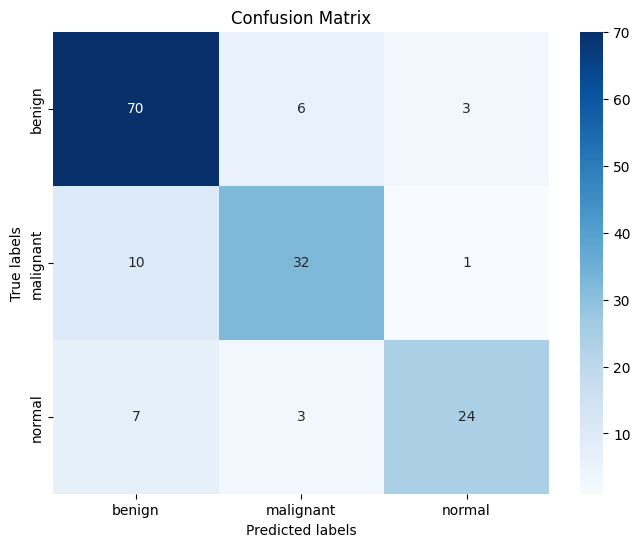

{'model': 'vgg16', 'fold': 4, 'confusion_matrix': array([[70,  6,  3],
       [10, 32,  1],
       [ 7,  3, 24]], dtype=int64), 'accuracy': 0.8076923076923077, 'precision_per_class': [0.8045977011494253, 0.7804878048780488, 0.8571428571428571], 'recall_per_class': [0.8860759493670886, 0.7441860465116279, 0.7058823529411765], 'f1_score_per_class': [0.8433734939759037, 0.7619047619047619, 0.7741935483870968], 'precision_macro': 0.8140761210567771, 'recall_macro': 0.7787147829399643, 'f1_score_macro': 0.7931572680892541, 'auc': None, 'kappa': 0.6826688364524003}
---------
Starting Fold: 5 ...
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 769s 30s/step - accuracy: 0.4342 - loss: 48.1748 - val_accuracy: 0.6795 - val_loss: 5.7430
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 338s 17s/step - accuracy: 0.7670 - loss: 3.9432 - val_accuracy: 0.8077 - val_loss: 2.6358
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 333s 17s/step - accuracy: 0.8340 - loss: 1.2595 - val_accuracy: 0.7628 - val_loss: 1.1544
5/5 ━━━━━━━━━━━━━━━━━

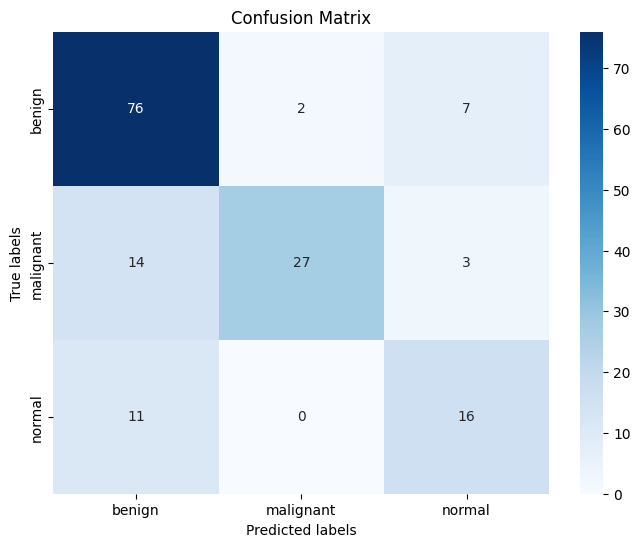

{'model': 'vgg16', 'fold': 5, 'confusion_matrix': array([[76,  2,  7],
       [14, 27,  3],
       [11,  0, 16]], dtype=int64), 'accuracy': 0.7628205128205128, 'precision_per_class': [0.7524752475247525, 0.9310344827586207, 0.6153846153846154], 'recall_per_class': [0.8941176470588236, 0.6136363636363636, 0.5925925925925926], 'f1_score_per_class': [0.8172043010752689, 0.7397260273972602, 0.6037735849056604], 'precision_macro': 0.7662981152226629, 'recall_macro': 0.7001155344292599, 'f1_score_macro': 0.7202346377927298, 'auc': None, 'kappa': 0.5809191897190156}


In [9]:
# Loop para validação cruzada k-fold
i = 1
for train_index, val_index in kf.split(images):
    
    print(f'---------\nStarting Fold: {i} ...')
    
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Calcular pesos das classes
    class_weights = compute_class_weights(y_train)

    # Criar o modelo
    model = get_model(input_shape, num_classes)

    # Treinar o modelo com pesos de classe
    model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), class_weight=class_weights)

    # Fazer previsões no conjunto de validação
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Gerar os resultados
    plot_cm(y_true, y_pred_classes, label_encoder)
    results = classification_metrics_multiclass(y_true, y_pred_classes, 'vgg16', i)
    print(results)
    i += 1
    
    # Garantir que zerou o modelo para o proximo loop do k-fold
    del model